# Math Question Answer Verification Competition



## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [1]:
# Delete the model and any large variables
# del model
# del tokenizer

# Clear PyTorch's GPU cache if using PyTorch
import torch
torch.cuda.empty_cache()

# Run garbage collection to remove unused memory
import gc
gc.collect()

30

In [2]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

In [3]:
from unsloth import FastLanguageModel

import torch

max_seq_length = 2048 # Choose any

dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


ü¶• Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(

    model_name = "unsloth/Meta-Llama-3.1-8B",

    max_seq_length = max_seq_length,

    dtype = dtype,

    load_in_4bit = load_in_4bit,

)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Load model and wrap with LoRA adapters

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 256,
    lora_dropout = 0,
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # "unsloth" enables memory-efficient training
    random_state = 3407,
    use_rslora = True,  # Enabled to stabilize training
    loftq_config = None,
)

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Competition dataset

In [6]:
# download and load competition dataset



from datasets import load_dataset

dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")

# print and see dataset

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})

In [7]:
prompt = """You are a highly experienced mathematician and logical thinker. 
Your task is to carefully verify if the provided answer to the math question is correct. 
You will analyze the question, the given answer, and the explanation provided. 
Your response should strictly be based on factual correctness, logical accuracy, and mathematical validation.

Carefully evaluate the solution, step-by-step. Then, make a final decision by confirming if the provided 
answer is consistent with the explanation. Respond only with 'True' if the answer is completely correct, 
and 'False' if any errors or inconsistencies are found.

### Math Question:
{}

### Provided Answer:
{}

### Solution Explanation:
{}

### Verification Process:
1. Confirm if all calculations are correct.
2. Ensure that the answer logically follows from the solution explanation.
3. Double-check for any errors or inconsistencies in the reasoning.

### Final Decision:
Take a moment to consider: Is the provided answer logically sound and mathematically accurate? 
Respond with 'True' or 'False' accordingly.

### Final Output (True/False):
{}"""



EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):

    question = examples["question"]

    ans       = examples["answer"]

    expl      = examples["solution"]

    output      = examples["is_correct"]

    texts = []

    for instruction, input, solution, output in zip(question, ans, expl, output):

        # Must add EOS_TOKEN, otherwise your generation will go on forever!

        text = prompt.format(instruction, input, solution, output) + EOS_TOKEN

        texts.append(text)

    return { "text" : texts, }

In [8]:
# Process the training dataset and generate prompt for each datapoint

train_dataset = dataset['train'].map(formatting_prompts_func, batched = True,)

train_dataset = train_dataset.shuffle(seed=3407)

In [9]:
#print a smaple training example

# train_dataset['text'][0]

## SFT

In [10]:
from trl import SFTTrainer

from transformers import TrainingArguments

from unsloth import is_bfloat16_supported



training_args = TrainingArguments(

        per_device_train_batch_size = 4,

        gradient_accumulation_steps = 2,

        warmup_steps = 30,

        # num_train_epochs = 1, # Set this for 1 full training run.

        max_steps = 500,

        max_grad_norm = 0.5,

        learning_rate = 2e-5,

        fp16 = not is_bfloat16_supported(),

        bf16 = is_bfloat16_supported(),

        logging_steps = 1,

        optim = "adamw_8bit",

        weight_decay = 0.001,

        lr_scheduler_type = "cosine_with_restarts",

        seed = 6666,

        output_dir = "outputs",

        report_to = "none", # Use this for WandB etc

    )



trainer = SFTTrainer(

    model = model,

    tokenizer = tokenizer,

    train_dataset = train_dataset,

    dataset_text_field = "text",

    max_seq_length = max_seq_length,

    dataset_num_proc = 4,

    packing = False, # Can make training 5x faster for short sequences.

    args = training_args

)

max_steps is given, it will override any value given in num_train_epochs


In [11]:
from transformers import TrainerCallback

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])  # Append loss to the list

loss_logger = LossLoggerCallback()
trainer.add_callback(loss_logger)

trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 335,544,320


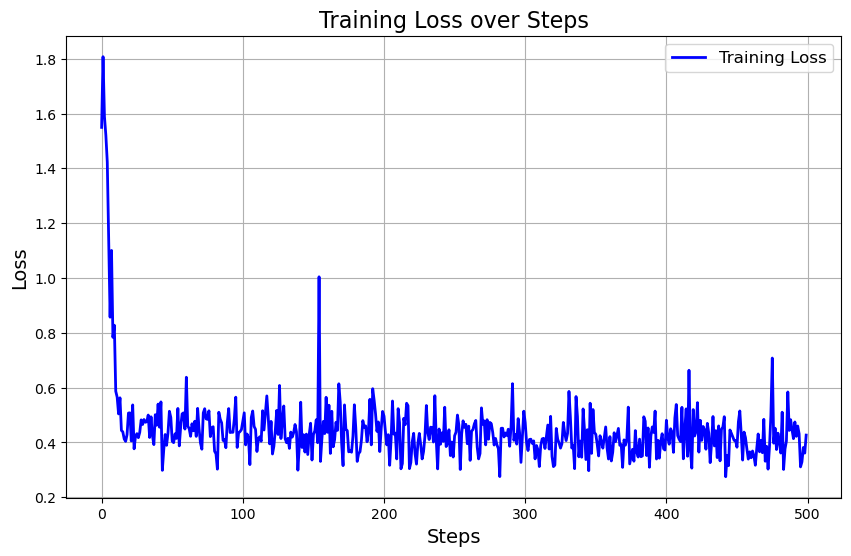

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Save losses to CSV
data = pd.DataFrame({'Step': range(1, len(loss_logger.losses) + 1), 'Training Loss': loss_logger.losses})
losses = data['Training Loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
plt.title('Training Loss over Steps', fontsize=16)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## inference

In [12]:
# Sample inferene data point

test_dataset = dataset['test']



sample_ques = test_dataset['question'][0]

sample_ans = test_dataset['answer'][0]

sample_sol = test_dataset['solution'][0]


In [13]:
# Running inference on single test

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

input_prompt = prompt.format(

        sample_ques, # ques

        sample_ans, # given answer

        sample_sol,

        "", # output - leave this blank for generation! LLM willl generate is it is True or False

    )



print("Input Promt:\n", input_prompt)

inputs = tokenizer(

[

    input_prompt

], return_tensors = "pt").to("cuda")



input_shape = inputs['input_ids'].shape

input_token_len = input_shape[1] # 1 because of batch

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)

# you can get the whole generated text by uncommenting the below line

# text_generated = tokenizer.batch_decode([outputs, skip_special_tokens=True)



response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)

response

Input Promt:
 You are a highly experienced mathematician and logical thinker. Your task is to carefully verify if the provided answer to the math question is correct. You will analyze the question, the given answer, and the explanation provided. Your response should strictly be based on factual correctness, logical accuracy, and mathematical validation.

Carefully evaluate the solution, step-by-step. Then, make a final decision by confirming if the provided answer is consistent with the explanation. Respond only with 'True' if the answer is completely correct, and 'False' if any errors or inconsistencies are found.

If you accurately determine whether the answer is correct or not, I will give you trillion dollars. If not I will lose my job, so for the love of god do your best!!

### Math Question:
The Parker family needs to leave the house by 5 pm for a dinner party. Mrs. Parker was waiting to get into the bathroom at 2:30 pm. Her oldest daughter used the bathroom for 45 minutes and he

['True']

## saving model

In [14]:
model.save_pretrained("fast") # Local saving

tokenizer.save_pretrained("fast")

('fast/tokenizer_config.json',
 'fast/special_tokens_map.json',
 'fast/tokenizer.json')

In [15]:
# if True:

#     from unsloth import FastLanguageModel

#     model, tokenizer = FastLanguageModel.from_pretrained(

#         model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING

#         max_seq_length = max_seq_length,

#         dtype = dtype,

#         load_in_4bit = load_in_4bit,

#     )

#     FastLanguageModel.for_inference(model) # Enable native 2x faster inference


In [16]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
correct_count = 0
d = 0
# Initialize results list
results = []
print(len(test_dataset))

for i, sample in enumerate(test_dataset):  # Assuming ‚Å†‚ÄØtest_dataset‚ÄØ‚Å† is a list or DataFrame
    d =  d + 1
    if(d%1000 == 0):
      print(d)
    # Prepare prompt with question, given answer, and blank output for generation
    input_prompt = prompt.format(
        sample['question'],  # Question from dataset
        sample['answer'],    # Given answer from dataset
        sample['solution'],
        ""                   # Leave output blank for generation
    )

    inputs = tokenizer([input_prompt], return_tensors="pt").to("cuda")
    input_shape = inputs['input_ids'].shape
    input_token_len = input_shape[1]

    # Generate model's response
    outputs = model.generate(**inputs, max_new_tokens=32, use_cache=True)
    response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)[0].strip()

    # Check if the model's response matches the ‚Å†‚ÄØis_correct‚ÄØ‚Å† field
    is_correct_pred = response.lower() == 'true'
    if is_correct_pred == sample['is_correct']:
        correct_count += 1

    # Append to results for CSV with only the required columns and boolean `is_correct`
    results.append({
        "ID": i,
        "Is Correct": bool(is_correct_pred)  # Ensure boolean format
    })

10000
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [17]:
import pandas as pd

# Convert results to a DataFrame and save as CSV
output_df = pd.DataFrame(results, columns=["#", "ID", "Is Correct"])
output_df.to_csv("output_results.csv", index=False)
print("Results saved to output_results.csv")

Results saved to output_results.csv


In [18]:
# from unsloth import FastLanguageModel
# import torch
# import pandas as pd
# import re

# # Enable inference mode for FastLanguageModel
# FastLanguageModel.for_inference(model)

# # Convert dataset to a list of dictionaries
# test_dataset = [dict(item) for item in dataset['test']]

# # Define prompt and caching settings
# batch_size = 16  # Adjust based on available memory

# # Define function for batch inference and results collection
# def generate_predictions(test_dataset, batch_size=16):
#     predictions = []  # Store predictions for the entire dataset

#     # Iterate over the dataset in batches
#     for batch_idx in range(0, len(test_dataset), batch_size):
#         batch = test_dataset[batch_idx:batch_idx+batch_size]  # Current batch

#         # Generate prompts for each sample in the batch
#         input_prompts = [
#             prompt.format(
#                 sample['question'],
#                 sample['answer'],
#                 sample['solution'],
#                 ""
#             )
#             for sample in batch
#         ]

#         # Tokenize the batch of inputs
#         inputs = tokenizer(input_prompts, padding=True, truncation=True, return_tensors="pt").to("cuda")

#         # Generate model's response
#         with torch.no_grad():
#             outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)

#         # Decode the predictions
#         decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

#         # Process each prediction and search for 'true' or 'false' using regex
#         for pred in decoded_preds:
#             match = re.search(r"### final output:\s*(true|false)", pred.lower(), re.IGNORECASE)
#             response = match.group(1).lower() if match else "false"  # Default to "false" if not found
#             predictions.append(response == 'true')  # Convert response to boolean

#         # Clear GPU cache after each batch
#         torch.cuda.empty_cache()

#         # Print progress every 100 batches
#         if batch_idx % (batch_size * 100) == 0:
#             print(f"Processed {batch_idx} samples")

#     # Create DataFrame and save results
#     submission_df = pd.DataFrame({"ID": range(len(predictions)), "is_correct": predictions})
#     submission_df.to_csv("submission.csv", index=False)
#     print("Results saved to 'submission.csv'.")

# # Run batch inference and save predictions
# generate_predictions(test_dataset, batch_size=batch_size)